In [ ]:
#Unet++Net
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tifffile as tiff

from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/images'
masks_path = '/content/drive/MyDrive/positions'

# Load and check datasets
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.txt')])
if len(images) != len(masks):
    raise ValueError("Number of images and masks do not match.")

# Load TIFF images
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Parse cell data and generate binary masks
def parse_cell_data(file_path):
    with open(file_path, 'r') as file:
        cell_data = []
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell = {
                    "x1": int(parts[4]),
                    "y1": int(parts[5]),
                    "x2": int(parts[6]),
                    "y2": int(parts[7])
                }
                cell_data.append(cell)
    return cell_data

def create_binary_mask(cell_data, image_size=(256, 256)):
    mask = np.zeros(image_size, dtype=np.uint8)
    for cell in cell_data:
        cv2.rectangle(mask, (cell["x1"], cell["y1"]), (cell["x2"], cell["y2"]), color=255, thickness=-1)
    return np.expand_dims(mask, axis=-1)

# Split data
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Enhance image (histogram equalization, etc.)
def enhance_image(img):
    img = (img * 255).astype(np.uint8)
    img = cv2.equalizeHist(img) if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.GaussianBlur(img, (5, 5), 0), axis=-1)
    return img

# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256), batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_paths = [self.image_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        x = np.empty((self.batch_size, *self.image_size, 1))
        y = np.empty((self.batch_size, *self.image_size, 1))

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img = load_tiff_image(img_path)
            img = enhance_image(cv2.resize(img, self.image_size))

            cell_data = parse_cell_data(mask_path)
            mask = create_binary_mask(cell_data, self.image_size)

            x[i], y[i] = img / 255.0, mask / 255.0
        return x, y

def unetplusplus_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

unet2model = unetplusplus_model(input_size=(256, 256, 1))

unet2model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up generators and callbacks
train_gen = DataGenerator(train_images, train_masks)
val_gen = DataGenerator(val_images, val_masks)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train model
history = unet2model.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[early_stopping])

# Evaluation on test set
test_gen = DataGenerator(test_images, test_masks)
y_pred = unet2model.predict(test_gen)
y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat = y_pred.flatten()



Mounted at /content/drive
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 521s 5s/step - accuracy: 0.8961 - loss: 0.5654 - val_accuracy: 0.8966 - val_loss: 0.3330
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 629ms/step - accuracy: 0.9002 - loss: 0.3265 - val_accuracy: 0.8941 - val_loss: 0.3464
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 569ms/step - accuracy: 0.8993 - loss: 0.3317 - val_accuracy: 0.8939 - val_loss: 0.3405
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.8953 - loss: 0.3774 - val_accuracy: 0.8964 - val_loss: 0.3323
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.9016 - loss: 0.3293 - val_accuracy: 0.8958 - val_loss: 0.3353
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 565ms/step - accuracy: 0.8977 - loss: 0.3354 - val_accuracy: 0.8920 - val_loss: 0.3419
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 548ms/step - accuracy: 0.9005 - loss: 0.3252 - val_accuracy: 0.8931 - val_loss: 0.3377
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 563ms/step - accuracy: 0.8948 - loss: 0.3363 - val_accuracy: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


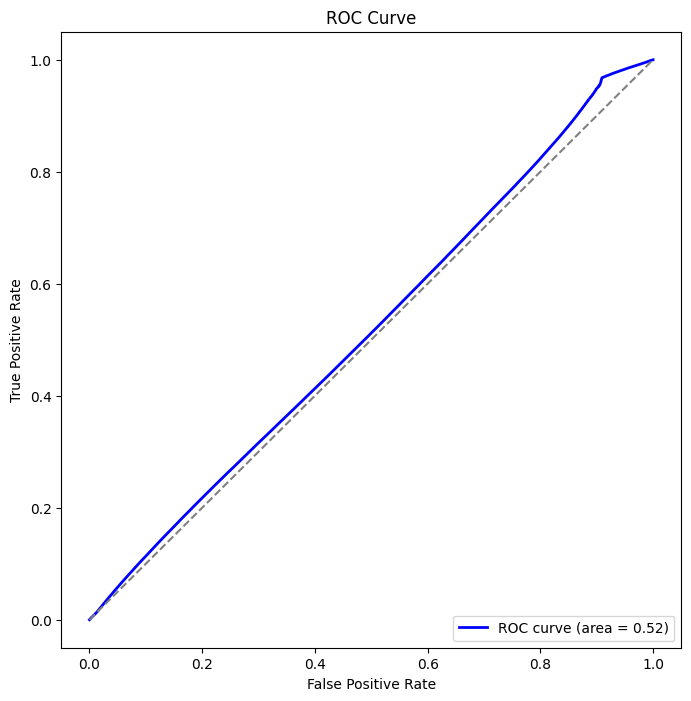

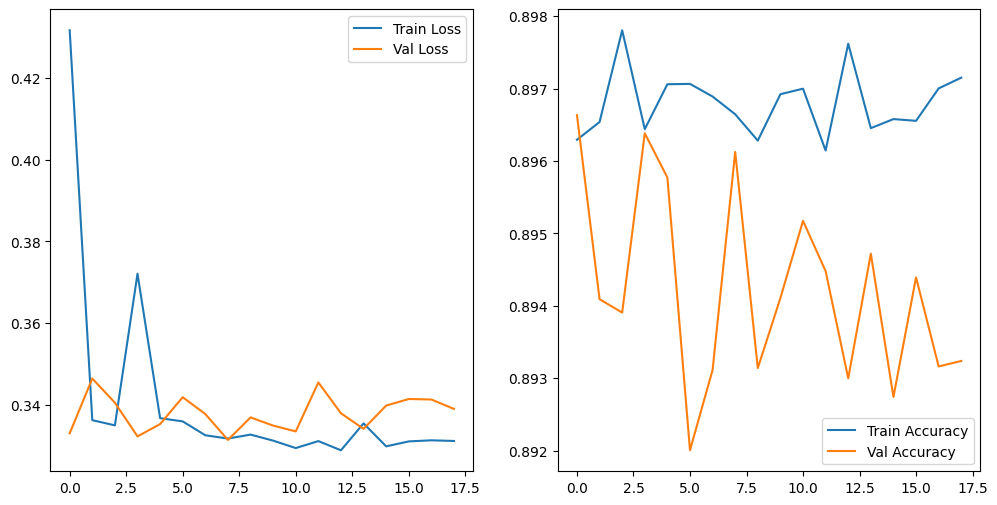

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.8825 - loss: 0.3613


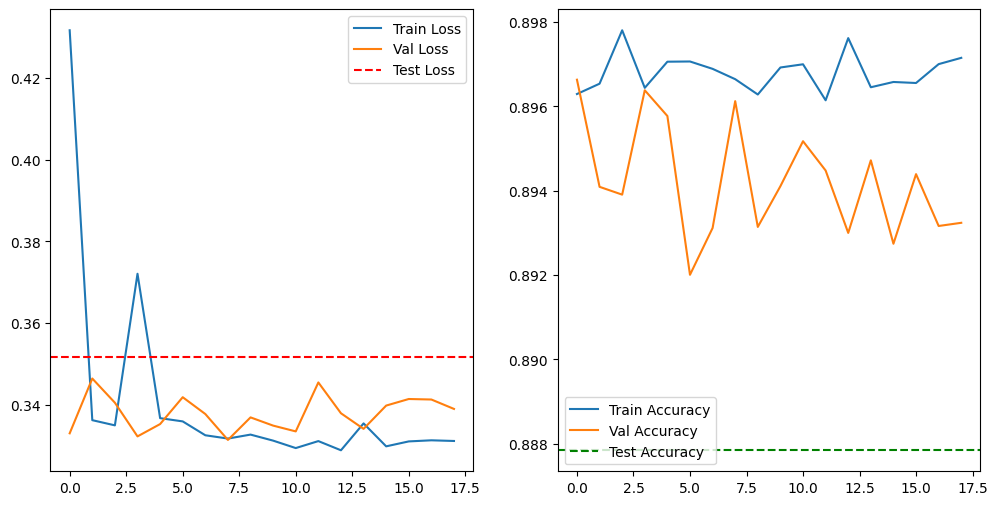

Accuracy: 0.8878,  IoU: 0.1122
Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes: 9.99787827358637
Dice Coefficient for Segmentation Boxes: 0.01913963990054387


In [ ]:
# Metrics calculations
accuracy = accuracy_score(y_true_flat, y_pred_flat > 0.5)


def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    if union_area == 0:
        return 0

    return intersection_area / union_area

iou = compute_iou_masks(y_true_flat, y_pred_flat)
# ROC Curve
fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

test_loss, test_accuracy = unet2model.evaluate(test_gen)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.legend()

plt.show()

# Output metrics
print(f"Accuracy: {accuracy:.4f},  IoU: {iou:.4f}")

import math
def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0
    num_samples = len(y_true)

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / num_samples

    if mse_avg == 0:
        return float('inf')
    else:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse_avg))


def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)


psnr_boxes = compute_psnr_boxes(y_true_flat, y_pred_flat)
dice_boxes = compute_dice_boxes(y_true_flat, y_pred_flat)



print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes:", psnr_boxes)
print("Dice Coefficient for Segmentation Boxes:", dice_boxes)


In [ ]:
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import directed_hausdorff
import numpy as np

def compute_ssim_boxes(y_true, y_pred):
    ssim_scores = []

    for mask_true, mask_pred in zip(y_true, y_pred):
        # Compute SSIM for each pair of masks (box)
        ssim_score = ssim(mask_true, mask_pred)
        ssim_scores.append(ssim_score)

    return np.mean(ssim_scores)

def compute_hausdorff_boxes(y_true, y_pred):
    hausdorff_distances = []

    for mask_true, mask_pred in zip(y_true, y_pred):
        # Get the coordinates of non-zero (foreground) pixels
        points_true = np.array(np.nonzero(mask_true)).T
        points_pred = np.array(np.nonzero(mask_pred)).T

        # Calculate directed Hausdorff distances in both directions
        hd_forward = directed_hausdorff(points_true, points_pred)[0]
        hd_backward = directed_hausdorff(points_pred, points_true)[0]

        # Hausdorff distance is the maximum of the two directed distances
        hausdorff_distances.append(max(hd_forward, hd_backward))

    return np.mean(hausdorff_distances)


ssim = compute_ssim_boxes(y_true_flat, y_pred_flat)
HD = compute_hausdorff_boxes(y_true_flat, y_pred_flat)

print("Structural Similarity Index (SSIM)", ssim)
print("Hausdorff Distance:", HD)

In [ ]:
#HRnet
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tifffile as tiff

from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/images'
masks_path = '/content/drive/MyDrive/positions'

# Load and check datasets
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.txt')])
if len(images) != len(masks):
    raise ValueError("Number of images and masks do not match.")

# Load TIFF images
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Parse cell data and generate binary masks
def parse_cell_data(file_path):
    with open(file_path, 'r') as file:
        cell_data = []
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell = {
                    "x1": int(parts[4]),
                    "y1": int(parts[5]),
                    "x2": int(parts[6]),
                    "y2": int(parts[7])
                }
                cell_data.append(cell)
    return cell_data

def create_binary_mask(cell_data, image_size=(256, 256)):
    mask = np.zeros(image_size, dtype=np.uint8)
    for cell in cell_data:
        cv2.rectangle(mask, (cell["x1"], cell["y1"]), (cell["x2"], cell["y2"]), color=255, thickness=-1)
    return np.expand_dims(mask, axis=-1)

# Split data
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Enhance image (histogram equalization, etc.)
def enhance_image(img):
    img = (img * 255).astype(np.uint8)
    img = cv2.equalizeHist(img) if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.GaussianBlur(img, (5, 5), 0), axis=-1)
    return img

# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256), batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_paths = [self.image_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        x = np.empty((self.batch_size, *self.image_size, 1))
        y = np.empty((self.batch_size, *self.image_size, 1))

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img = load_tiff_image(img_path)
            img = enhance_image(cv2.resize(img, self.image_size))

            cell_data = parse_cell_data(mask_path)
            mask = create_binary_mask(cell_data, self.image_size)

            x[i], y[i] = img / 255.0, mask / 255.0
        return x, y

def hrnet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    maxpool1 = MaxPooling2D()(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(maxpool1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    maxpool2 = MaxPooling2D()(conv4)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(maxpool2)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    maxpool3 = MaxPooling2D()(conv6)
    conv7 = Conv2D(512, 3, activation='relu', padding='same')(maxpool3)
    conv8 = Conv2D(512, 3, activation='relu', padding='same')(conv7)
    upsample1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv8)
    concat1 = concatenate([upsample1, conv6], axis=3)
    conv9 = Conv2D(256, 3, activation='relu', padding='same')(concat1)
    conv10 = Conv2D(256, 3, activation='relu', padding='same')(conv9)
    upsample2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv10)
    concat2 = concatenate([upsample2, conv4], axis=3)
    conv11 = Conv2D(128, 3, activation='relu', padding='same')(concat2)
    conv12 = Conv2D(128, 3, activation='relu', padding='same')(conv11)
    upsample3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv12)
    concat3 = concatenate([upsample3, conv2], axis=3)
    conv13 = Conv2D(64, 3, activation='relu', padding='same')(concat3)
    conv14 = Conv2D(64, 3, activation='relu', padding='same')(conv13)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv14)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hrmodel = hrnet_model(input_size=(256, 256, 1))


hrmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up generators and callbacks
train_gen = DataGenerator(train_images, train_masks)
val_gen = DataGenerator(val_images, val_masks)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train model
history = hrmodel.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[early_stopping])

# Evaluation on test set
test_gen = DataGenerator(test_images, test_masks)
y_pred = hrmodel.predict(test_gen)
y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat = y_pred.flatten()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - accuracy: 0.8745 - loss: 0.6045 - val_accuracy: 0.8931 - val_loss: 0.3420
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 374ms/step - accuracy: 0.8973 - loss: 0.3421 - val_accuracy: 0.8955 - val_loss: 0.3371
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 382ms/step - accuracy: 0.8980 - loss: 0.3311 - val_accuracy: 0.8932 - val_loss: 0.3395
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 375ms/step - accuracy: 0.9007 - loss: 0.3250 - val_accuracy: 0.8957 - val_loss: 0.3330
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 397ms/step - accuracy: 0.8945 - loss: 0.3417 - val_accuracy: 0.8925 - val_loss: 0.3430
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 373ms/step - accuracy: 0.8867 - loss: 0.3584 - val_accuracy: 0.8916 - val_loss: 0.3526
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - accuracy: 0.8969 - loss: 0.3349 - val_accuracy: 0.8922 - val_loss: 0.3411
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 399ms/step - accuracy: 0.8948 - loss: 0.3362 - val_accuracy

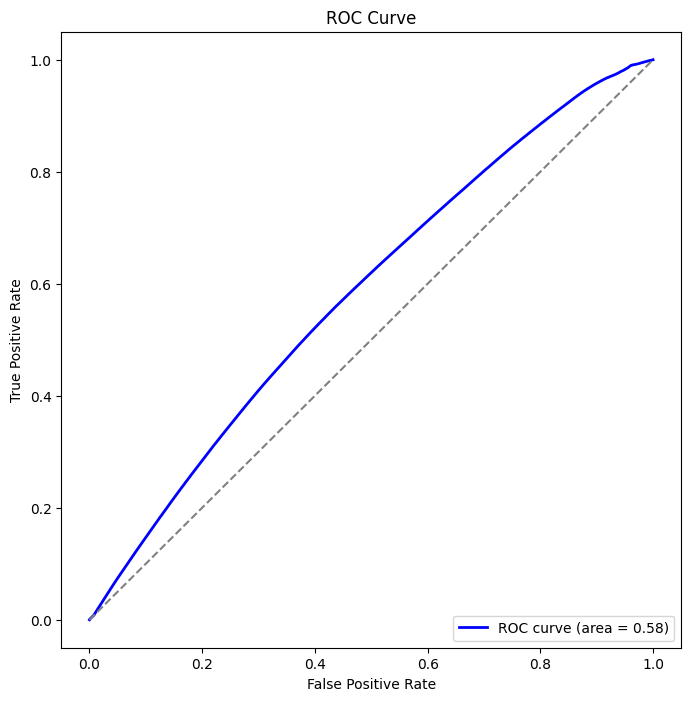

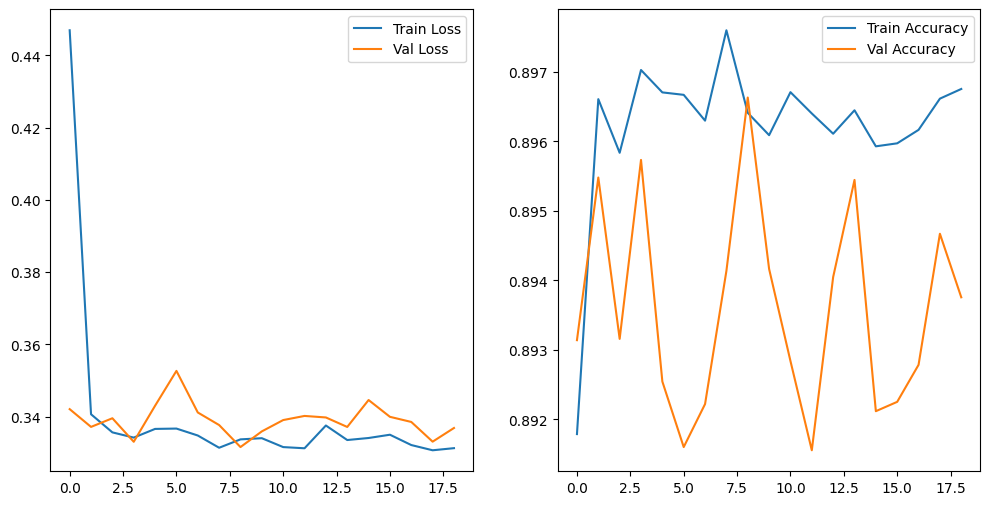

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8884 - loss: 0.3499


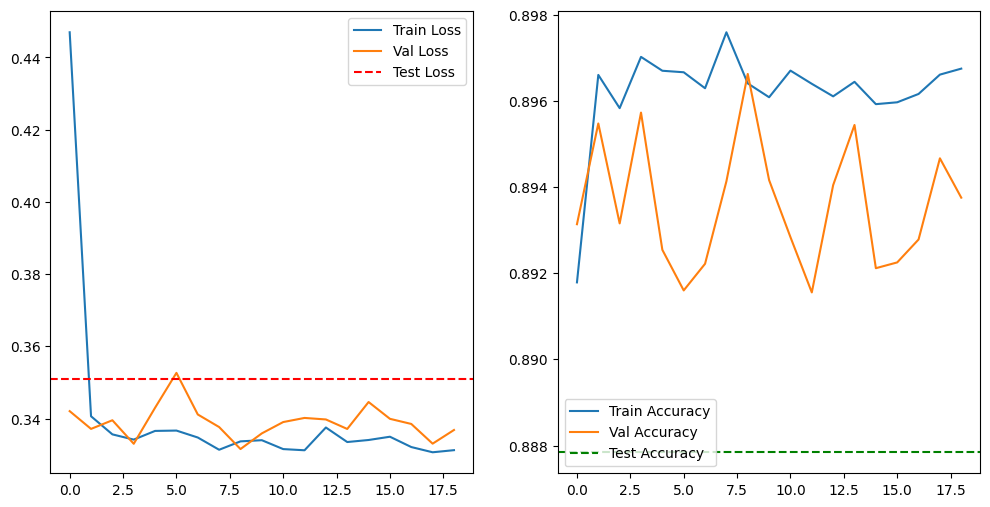

Accuracy: 0.8878,  IoU: 0.1122
Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes: 10.027712695232747
Dice Coefficient for Segmentation Boxes: 0.019420059877931186


In [ ]:
# Metrics calculations
accuracy = accuracy_score(y_true_flat, y_pred_flat > 0.5)


def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    if union_area == 0:
        return 0

    return intersection_area / union_area

iou = compute_iou_masks(y_true_flat, y_pred_flat)
# ROC Curve
fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

test_loss, test_accuracy = hrmodel.evaluate(test_gen)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.legend()

plt.show()

# Output metrics
print(f"Accuracy: {accuracy:.4f},  IoU: {iou:.4f}")

import math
def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0
    num_samples = len(y_true)

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / num_samples

    if mse_avg == 0:
        return float('inf')
    else:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse_avg))


def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)


psnr_boxes = compute_psnr_boxes(y_true_flat, y_pred_flat)
dice_boxes = compute_dice_boxes(y_true_flat, y_pred_flat)



print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes:", psnr_boxes)
print("Dice Coefficient for Segmentation Boxes:", dice_boxes)


In [ ]:
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import directed_hausdorff
import numpy as np

def compute_ssim_boxes(y_true, y_pred, eps=1e-6):
    ssim_scores = []

    for mask_true, mask_pred in zip(y_true, y_pred):
        # Ensure the images are in the right format (e.g., float32)
        mask_true = mask_true.astype(np.float32)
        mask_pred = mask_pred.astype(np.float32)

        # Handle edge cases where both masks are entirely blank (all zeroes)
        if np.all(mask_true == 0) and np.all(mask_pred == 0):
            ssim_scores.append(1.0)  # If both masks are blank, SSIM = 1
        elif np.all(mask_true == mask_pred):
            ssim_scores.append(1.0)  # If both masks are identical, SSIM = 1
        else:
            # Calculate the data_range based on the image range
            data_range = mask_true.max() - mask_true.min()

            # Check if the data range is too small (near zero variance)
            if data_range < eps:
                ssim_scores.append(0.0)  # If variance is zero, SSIM = 0
            else:
                # Compute SSIM for the current pair of masks
                score = ssim(mask_true, mask_pred, data_range=data_range)
                ssim_scores.append(score)

    return np.mean(ssim_scores)

def compute_hausdorff_boxes(y_true, y_pred):
    hausdorff_distances = []

    for mask_true, mask_pred in zip(y_true, y_pred):
        # Get the coordinates of non-zero (foreground) pixels
        points_true = np.array(np.nonzero(mask_true)).T
        points_pred = np.array(np.nonzero(mask_pred)).T

        # Calculate directed Hausdorff distances in both directions
        hd_forward = directed_hausdorff(points_true, points_pred)[0]
        hd_backward = directed_hausdorff(points_pred, points_true)[0]

        # Hausdorff distance is the maximum of the two directed distances
        hausdorff_distances.append(max(hd_forward, hd_backward))

    return np.mean(hausdorff_distances)


ssim = compute_ssim_boxes(y_true_flat, y_pred_flat)
HD = compute_hausdorff_boxes(y_true_flat, y_pred_flat)

print("Structural Similarity Index (SSIM)", ssim)
print("Hausdorff Distance:", HD)

Structural Similarity Index (SSIM) 0.0
Hausdorff Distance: inf
